## Percobaan 5

Ekualisasi, Mean, Sobel, Threshold, dan Closing

In [4]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

In [5]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            # Ambil channel hijau dari gambar
            green = img[:, :, 1]
            green = cv.resize(green, (150, 150)) # Resize gambar yag diambil
            green = green.astype(np.uint8)

            # img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            # img = cv.resize(img, (150, 150))  # Resize ke ukuran tetap
            # img = img.astype(np.uint8)

            data.append(green)
            labels.append(sub_folder)
            name = os.path.splitext(filename)[0]
            file_name.append(filename)

data = np.array(data)
labels = np.array(labels)

## Data Preparation


### Define Preprocessing

In [6]:
def histogram_equalization(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img_gray.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img_gray.shape).astype(np.uint8)

def mean_filter(img, kernel_size=3):
    pad = kernel_size // 2
    padded = np.pad(img, pad, mode='constant', constant_values=0)
    result = np.zeros_like(img, dtype=np.float32)  # Gunakan float32 untuk akurasi

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded[i:i+kernel_size, j:j+kernel_size]
            total = np.sum(window)
            result[i, j] = total / (kernel_size * kernel_size)
    
    return np.clip(result, 0, 255).astype(np.uint8)  # Clip dan konversi ke uint8

In [7]:
Sx = np.array([[-1,0,1],
               [-2,0,2],
               [-1,0,1]])

Sy = np.array([[1,2,1],
               [0,0,0],
               [-1,-2,-1]])

def sobel(img_gray):
   
    img_float = img_gray.astype(np.float32)

    rows, cols = img_float.shape

    Gx = np.zeros_like(img_float, dtype=np.float32)
    Gy = np.zeros_like(img_float, dtype=np.float32)

    kernel_size = 3
    pad_width = kernel_size // 2  

    padded_img = np.pad(img_float, pad_width, mode='symmetric')

    for i in range(rows):
        for j in range(cols):
            window = padded_img[i : i + kernel_size, j : j + kernel_size]

            Gx[i, j] = np.sum(window * Sx)
            Gy[i, j] = np.sum(window * Sy)

    G_magnitude = np.hypot(Gx, Gy)

    max_magnitude = np.max(G_magnitude)

    if max_magnitude > 0:
        G_normalized = (G_magnitude / max_magnitude) * 255.0
    else:
        G_normalized = G_magnitude 
        
    sobel_output = np.clip(G_normalized, 0, 255).astype(np.uint8)

    return sobel_output

def threshold(gambar, threshold):
    height, width = gambar.shape
    mask = np.zeros_like(gambar)

    for i in range(height):
        for j in range(width):
            if gambar[i, j] > threshold:
                mask[i, j] = 255
            else:
                mask[i, j] = 0

    return mask

In [8]:
def dilasi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.any(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def erosi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.all(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def opening(gambar, kernel):
    eroded = erosi(gambar, kernel)
    opened = dilasi(eroded, kernel)
    return opened.astype(np.uint8)

def closing(gambar, kernel):
    dilated = dilasi(gambar, kernel)
    closed = erosi(dilated, kernel)
    return closed.astype(np.uint8)


## Preprocessing

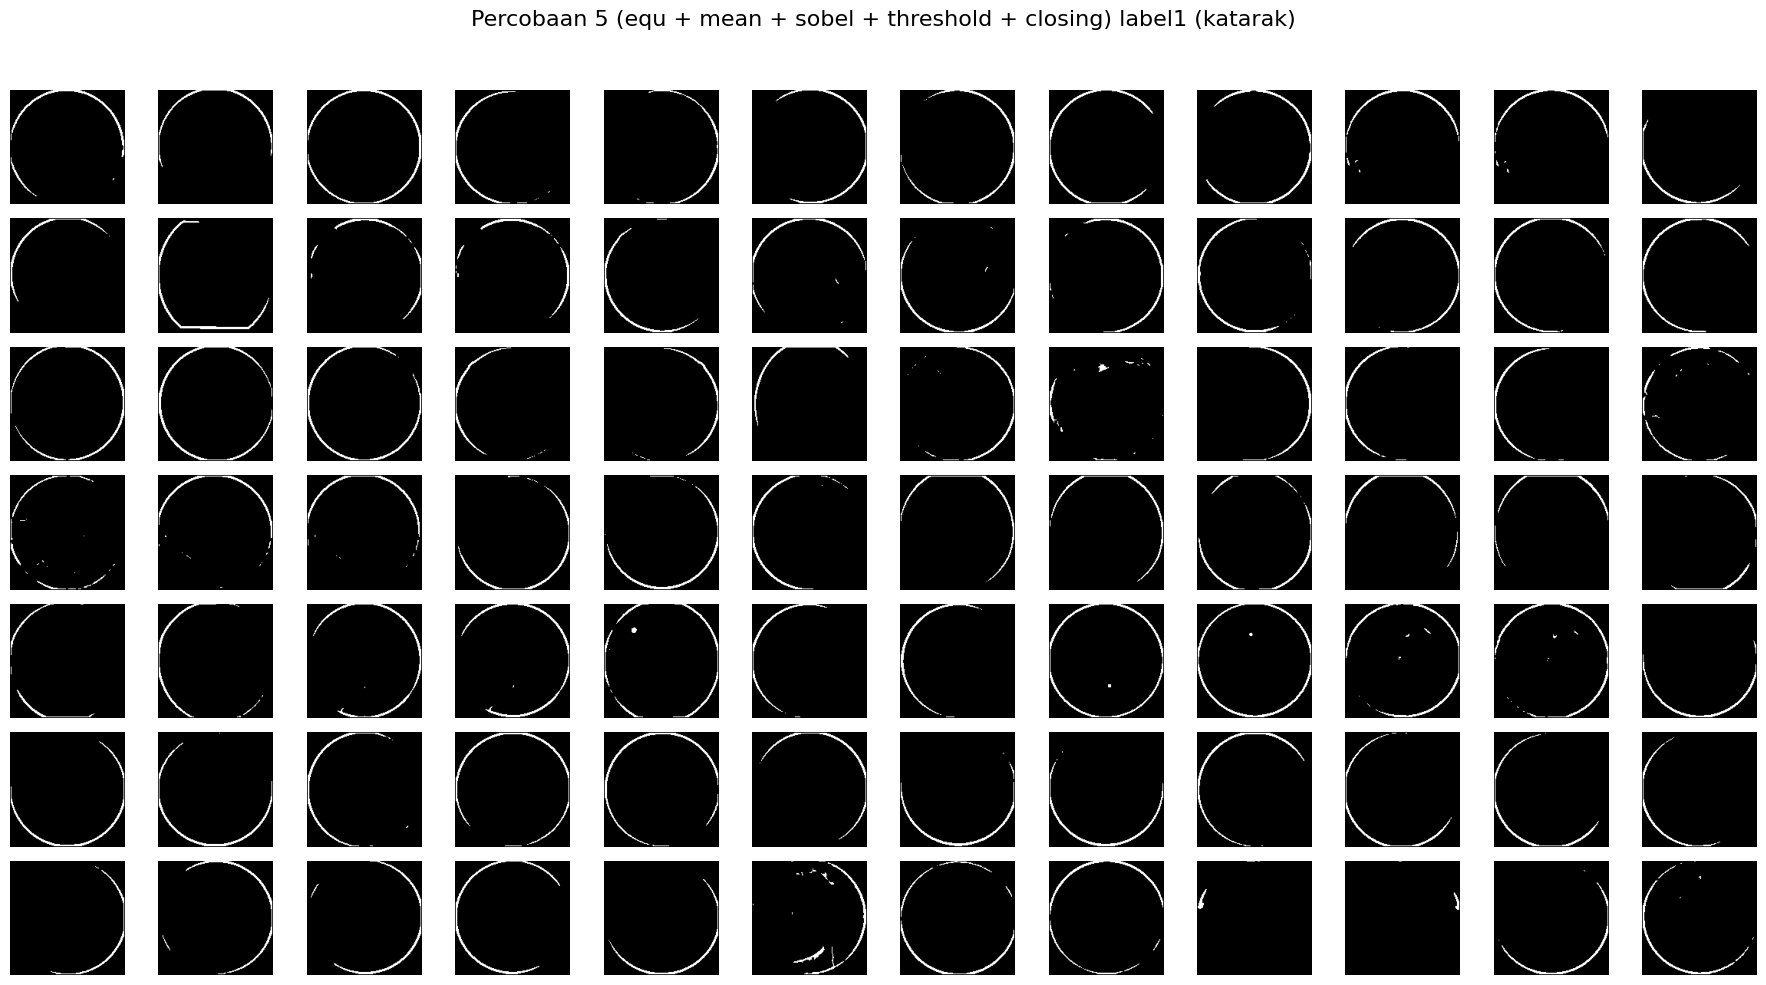

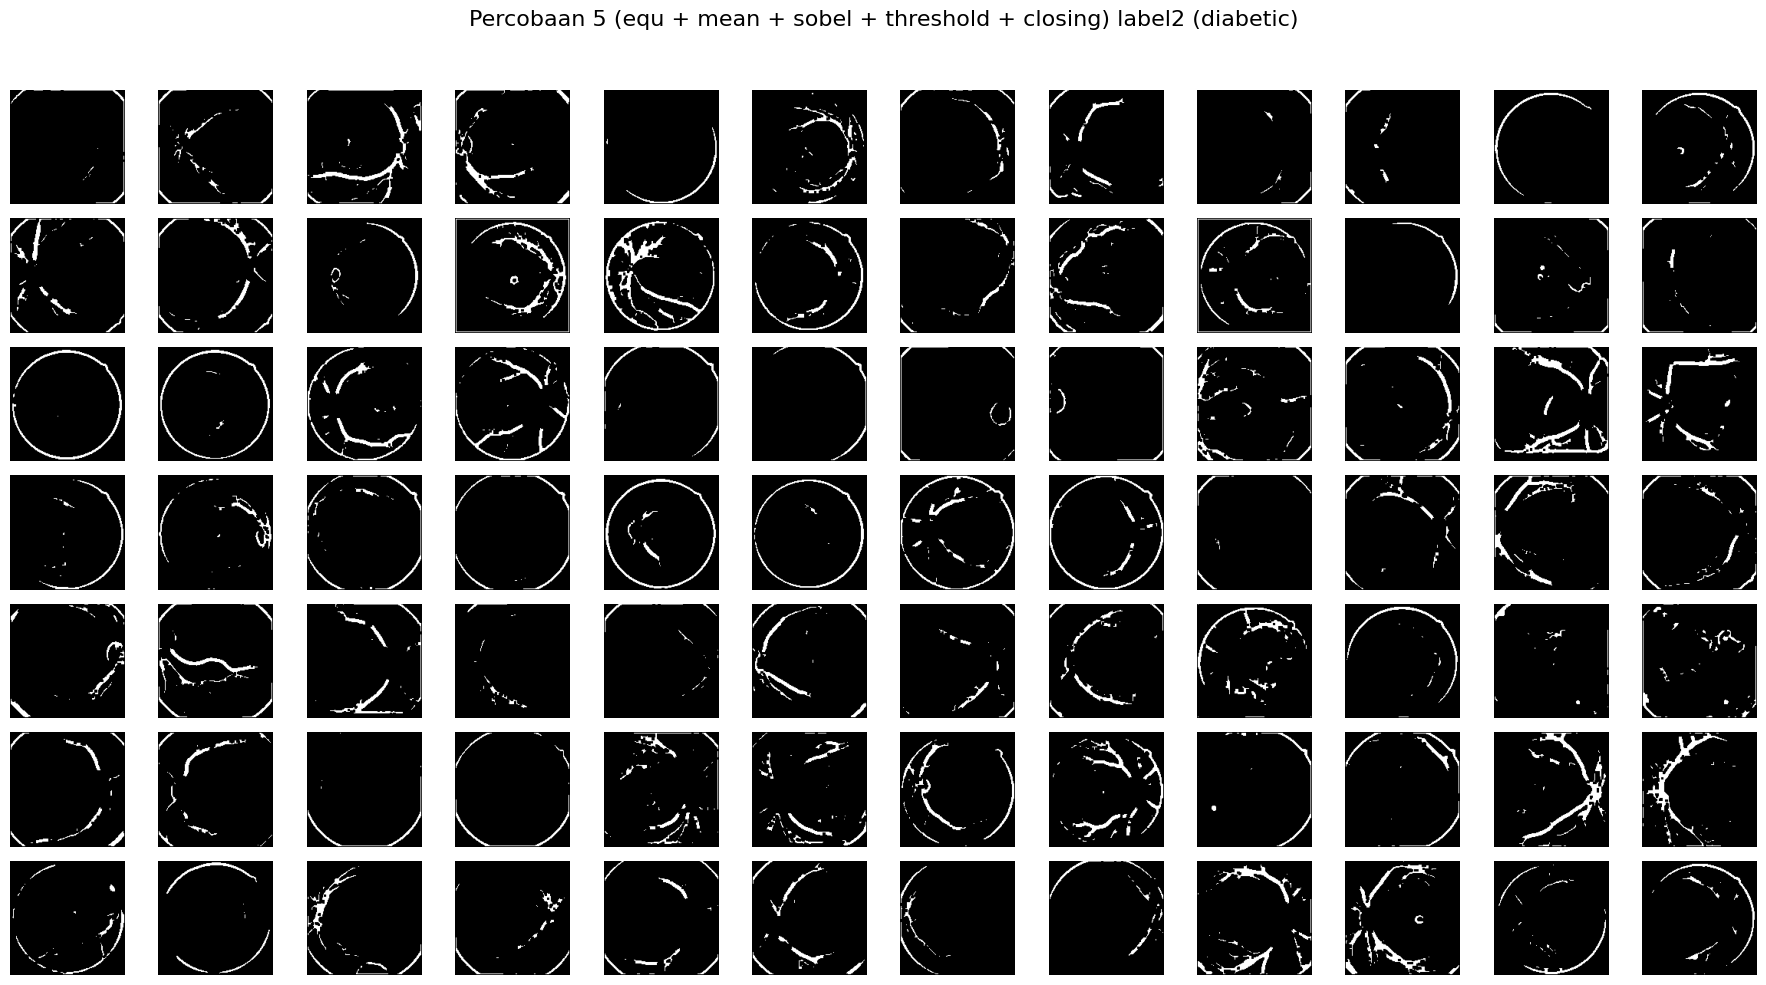

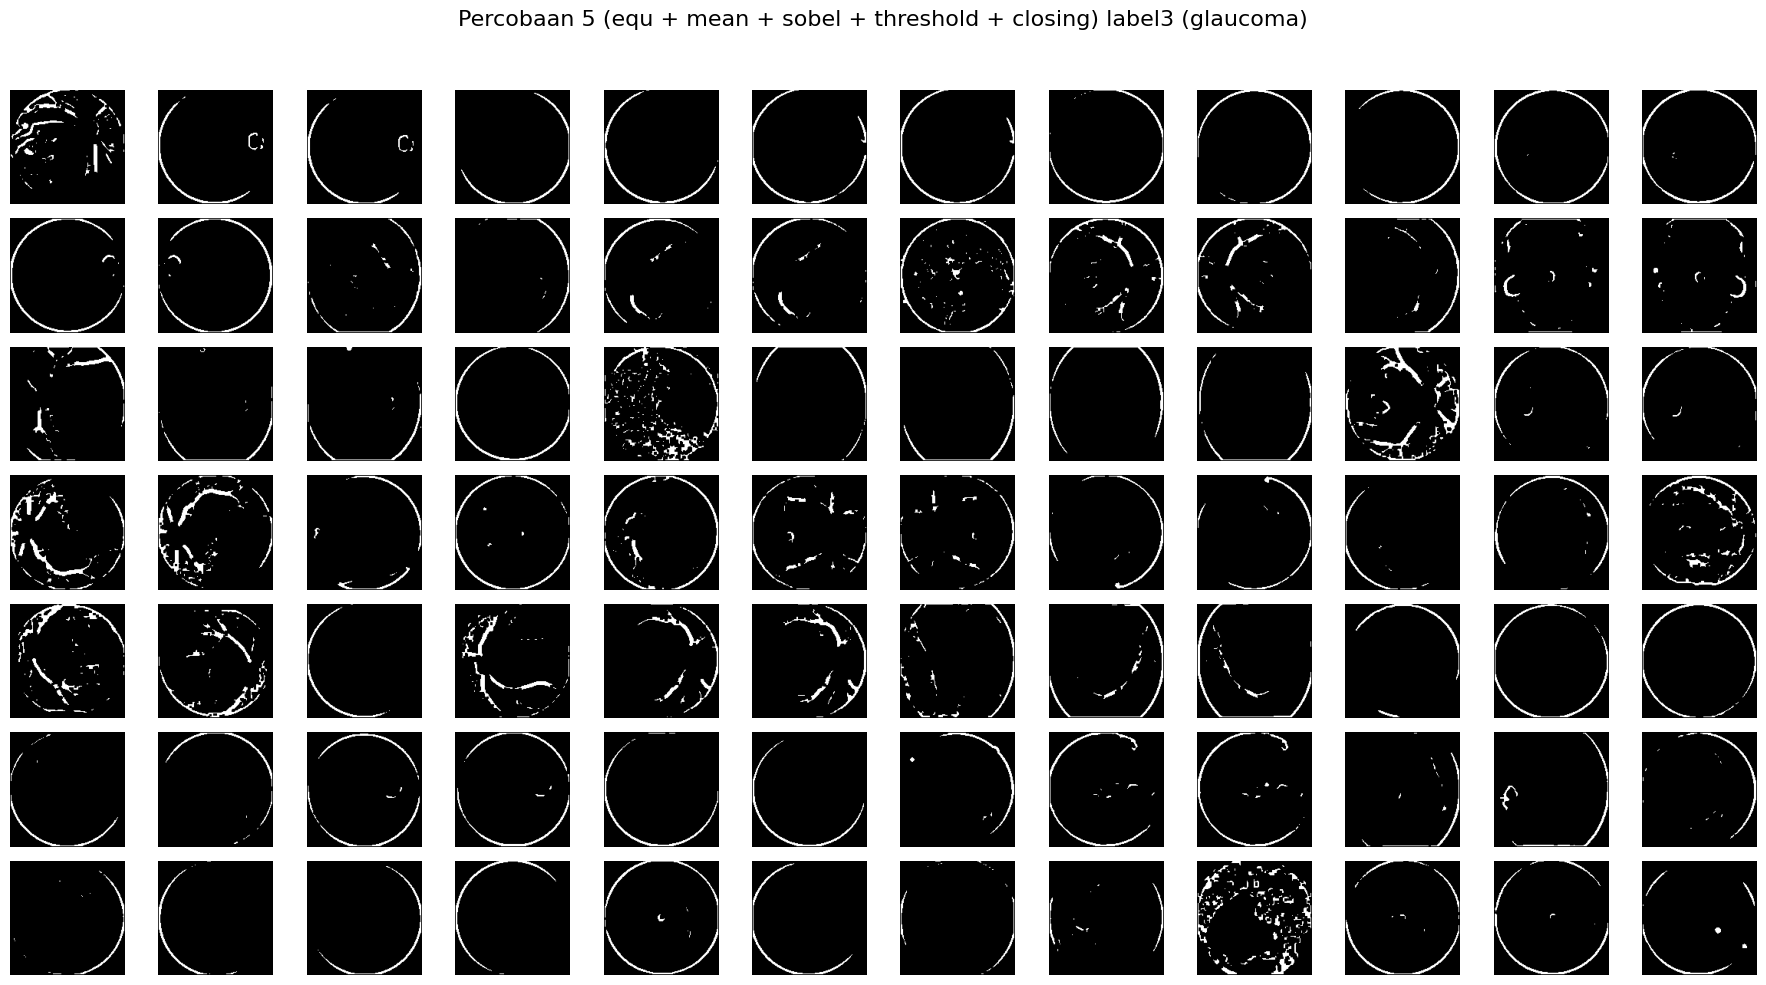

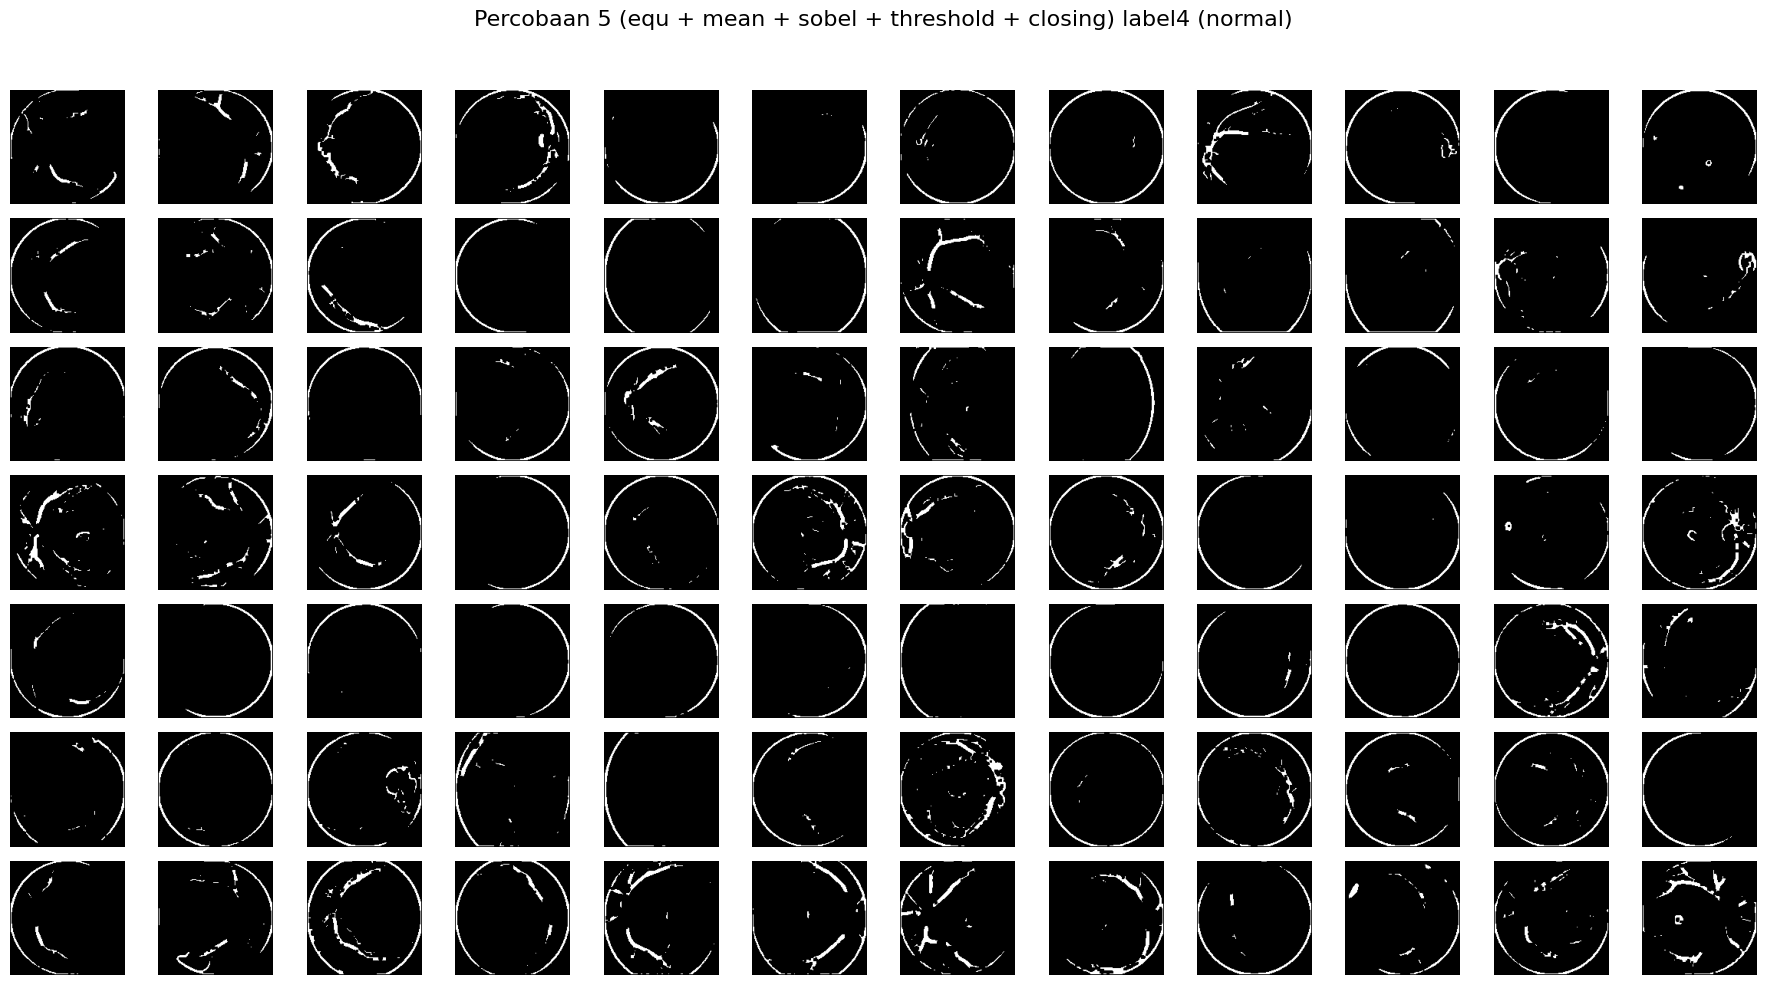

In [9]:
def percobaan5(green):
    img_eq = histogram_equalization(green)
    img_mean = mean_filter(img_eq)
    img_rob = sobel(img_mean)
    img_threshold = threshold(img_rob, 100)
    img_clos = closing(img_threshold, np.ones((3, 3)))
    return img_clos

dataPreprocessed = [percobaan5(img) for img in data]  

unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(7, 12, figsize=(18, 10))
    fig.suptitle(f'Percobaan 5 (equ + mean + sobel + threshold + closing) {label}', fontsize=16)
    
    for k in range(84):
        row = k // 12
        col = k % 12
        ax = axs[row][col]
        ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # beri ruang untuk judul
    plt.show()

## Ekstraksi Fitur

In [10]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    
    return glcm

In [11]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [12]:
# Fungsi ekstraksi fitur untuk list citra
def ekstrak_fitur_glcm(data, nama_prepro):
    fitur_list = []
    for img in data:
        img_u8 = img.astype(np.uint8)
        m = glcm(img_u8, 0)  # derajat 0
        
        fitur = {
            'contrast': contrast(m),
            'correlation': correlation(m),
            'energy': energy(m),
            'homogeneity': homogenity(m),
            'dissimilarity': dissimilarity(m),
            'ASM': ASM(m),
            'entropy': entropyGlcm(m)
        }
        fitur_list.append(fitur)

    df = pd.DataFrame(fitur_list)
    df['tahap'] = nama_prepro
    return df

df2 = ekstrak_fitur_glcm(dataPreprocessed, 'percobaan6')
display(df2)

,contrast,correlation,energy,homogeneity,dissimilarity,ASM,entropy,tahap
0,1192.852349,0.721475,0.957146,0.981656,4.677852,0.916129,0.220392,percobaan6
1,1082.295302,0.671868,0.965872,0.983356,4.244295,0.932908,0.184932,percobaan6
2,1600.167785,0.748105,0.937179,0.975392,6.275168,0.878304,0.296906,percobaan6
3,884.456376,0.730043,0.967573,0.986398,3.468456,0.936198,0.175487,percobaan6
4,890.275168,0.707538,0.969372,0.986309,3.491275,0.939682,0.168273,percobaan6
...,...,...,...,...,...,...,...,...
331,1605.986577,0.755024,0.935465,0.975302,6.297987,0.875094,0.302651,percobaan6
332,1646.718121,0.677170,0.947033,0.974676,6.457718,0.896872,0.263456,percobaan6
333,1123.026846,0.686696,0.963277,0.982730,4.404027,0.927903,0.195834,percobaan6
334,1745.637584,0.655612,0.946532,0.973155,6.845638,0.895923,0.266340,percobaan6


In [13]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)



## Hasil Ekstraksi to CSV

In [14]:
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        contrast(Derajat0[i]), contrast(Derajat45[i]), contrast(Derajat90[i]), contrast(Derajat135[i]),
        dissimilarity(Derajat0[i]), dissimilarity(Derajat45[i]), dissimilarity(Derajat90[i]), dissimilarity(Derajat135[i]),
        homogenity(Derajat0[i]), homogenity(Derajat45[i]), homogenity(Derajat90[i]), homogenity(Derajat135[i]),
        entropyGlcm(Derajat0[i]), entropyGlcm(Derajat45[i]), entropyGlcm(Derajat90[i]), entropyGlcm(Derajat135[i]),
        ASM(Derajat0[i]), ASM(Derajat45[i]), ASM(Derajat90[i]), ASM(Derajat135[i]),
        energy(Derajat0[i]), energy(Derajat45[i]), energy(Derajat90[i]), energy(Derajat135[i]),
        correlation(Derajat0[i]), correlation(Derajat45[i]), correlation(Derajat90[i]), correlation(Derajat135[i]),
    ]
    features.append(fitur)

# Buat dataframe
columns = [
    "contrast_0", "contrast_45", "contrast_90", "contrast_135",
    "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135",
    "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135",
    "entropy_0", "entropy_45", "entropy_90", "entropy_135",
    "ASM_0", "ASM_45", "ASM_90", "ASM_135",
    "energy_0", "energy_45", "energy_90", "energy_135",
    "correlation_0", "correlation_45", "correlation_90", "correlation_135"
]

df_fitur = pd.DataFrame(features, columns=columns)


In [15]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan5.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan5.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,_0_4015166.jpg,label1 (katarak),1192.852349,1405.882618,1088.114094,1751.495428,0.981656,0.978380,0.983266,0.973065,...,0.917683,0.907500,0.957146,0.955279,0.957958,0.952628,0.721475,0.673845,0.745931,0.593665
1,_10_3215668.jpg,label1 (katarak),1082.295302,1446.887528,890.275168,1499.608126,0.983356,0.977749,0.986309,0.976938,...,0.935772,0.926414,0.965872,0.962906,0.967353,0.962504,0.671868,0.564176,0.730085,0.548296
2,_11_7158929.jpg,label1 (katarak),1600.167785,2354.853385,1704.906040,2354.853385,0.975392,0.963786,0.973781,0.963786,...,0.876775,0.866784,0.937179,0.931012,0.936362,0.931012,0.748105,0.631641,0.731617,0.631641
3,_12_5233869.jpg,label1 (katarak),884.456376,1353.162020,971.738255,1335.588487,0.986398,0.979190,0.985056,0.979461,...,0.934894,0.929168,0.967573,0.963799,0.966899,0.963934,0.730043,0.589663,0.703402,0.594992
4,_13_3987009.jpg,label1 (katarak),890.275168,1347.304175,971.738255,1318.014954,0.986309,0.979281,0.985056,0.979731,...,0.938465,0.933021,0.969372,0.965707,0.968744,0.965930,0.707538,0.560279,0.680777,0.569838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,8_right.jpg,label4 (normal),1605.986577,2196.691590,1547.798658,2366.569073,0.975302,0.966218,0.976197,0.963606,...,0.875946,0.863474,0.935465,0.930539,0.935920,0.929233,0.755024,0.667026,0.763900,0.641276
332,939_left.jpg,label4 (normal),1646.718121,1968.235665,1280.134228,2220.122967,0.974676,0.969732,0.980314,0.965858,...,0.902256,0.888074,0.947033,0.944298,0.949871,0.942377,0.677170,0.616601,0.749037,0.567535
333,939_right.jpg,label4 (normal),1123.026846,1675.343453,1047.382550,1364.877708,0.982730,0.974236,0.983893,0.979010,...,0.929028,0.923967,0.963277,0.958862,0.963861,0.961232,0.686696,0.535635,0.707800,0.621689
334,951_left.jpg,label4 (normal),1745.637584,2542.304401,1710.724832,2225.980812,0.973155,0.960903,0.973692,0.965768,...,0.896432,0.888487,0.946532,0.940201,0.946801,0.942596,0.655612,0.501644,0.662500,0.563652


## Feature Selection

### Correlation

<Axes: >

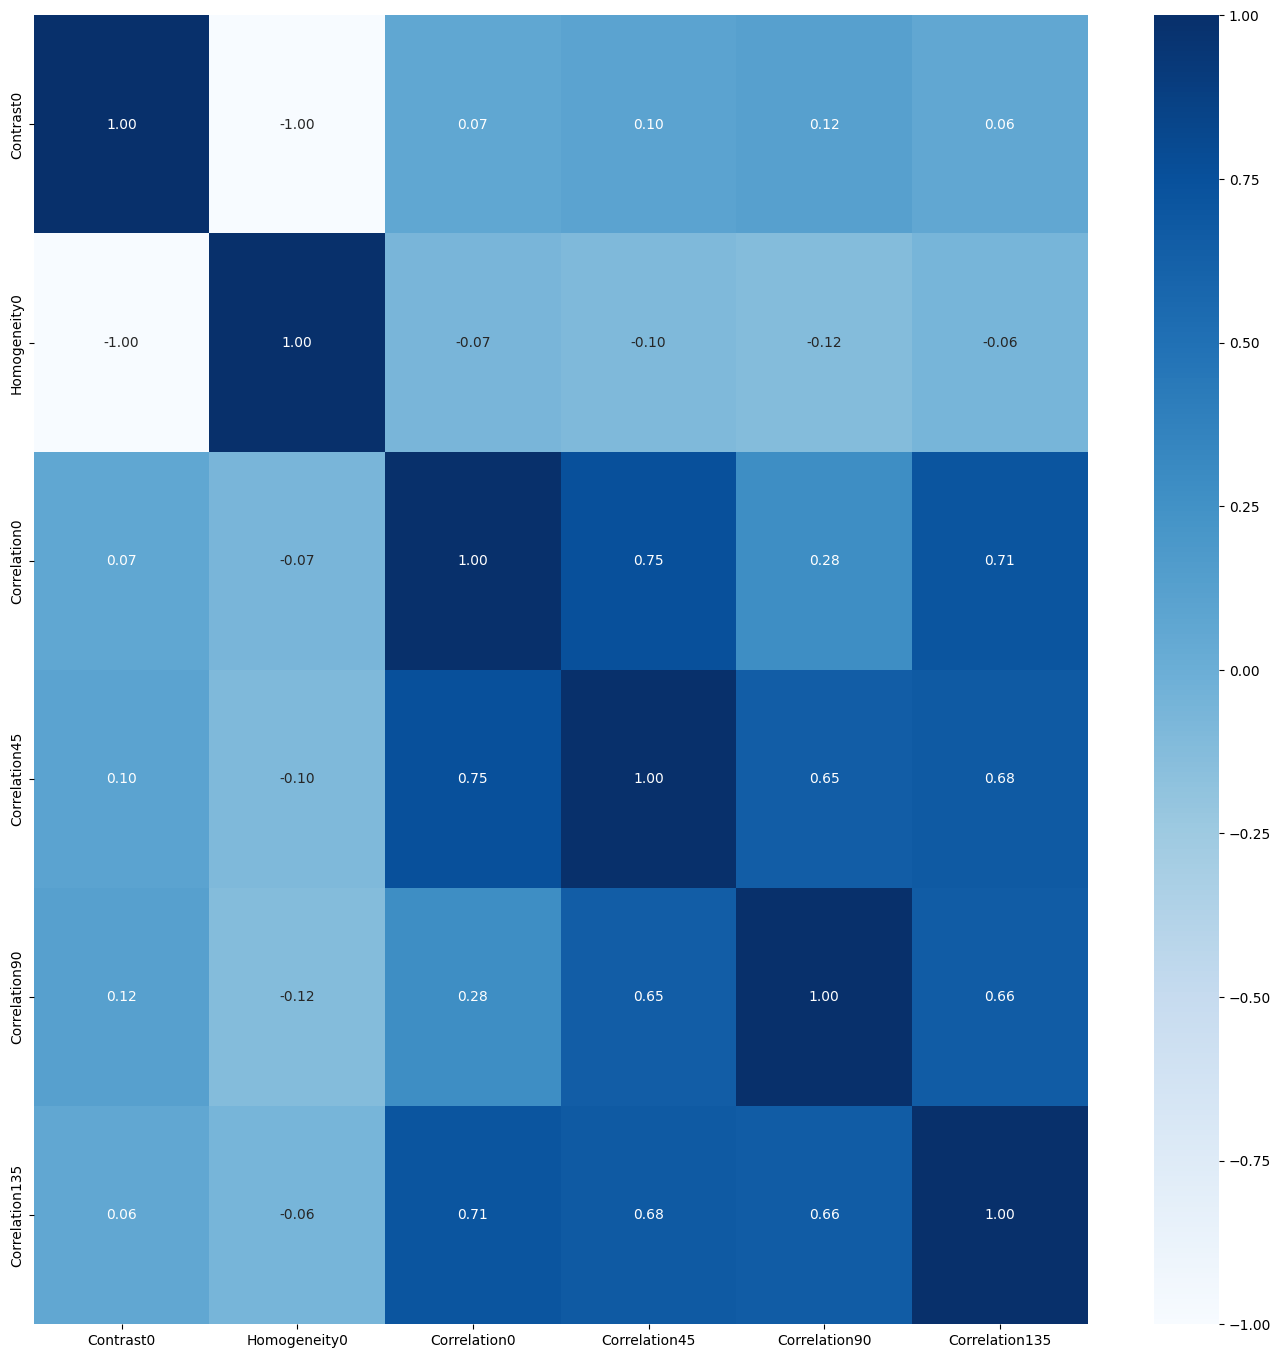

In [16]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### LDA

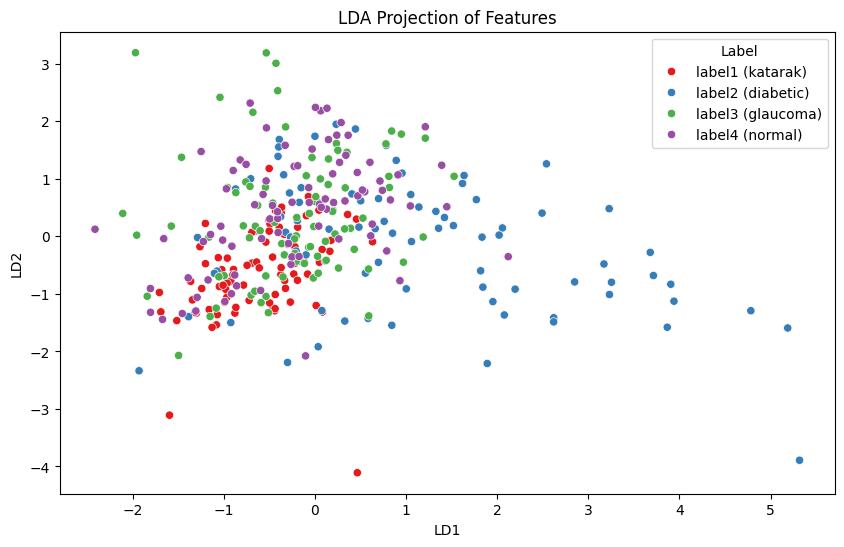

In [17]:
# Selection LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def feature_reduction_lda(dataframe, n_components=2):
    fitur = dataframe.drop(columns=['Label', 'Filename'])
    label = dataframe['Label']
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    x_lda = lda.fit_transform(fitur, label)
    
    columns = [f'LD{i+1}' for i in range(n_components)]
    df_lda = pd.DataFrame(x_lda, columns=columns)
    df_lda['Label'] = label.values
    
    return df_lda

lda_df = feature_reduction_lda(hasilEkstrak, n_components=2)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Label', palette='Set1')
plt.title('LDA Projection of Features')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Label')
plt.show()

### t-SNE

C:\Users\tami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


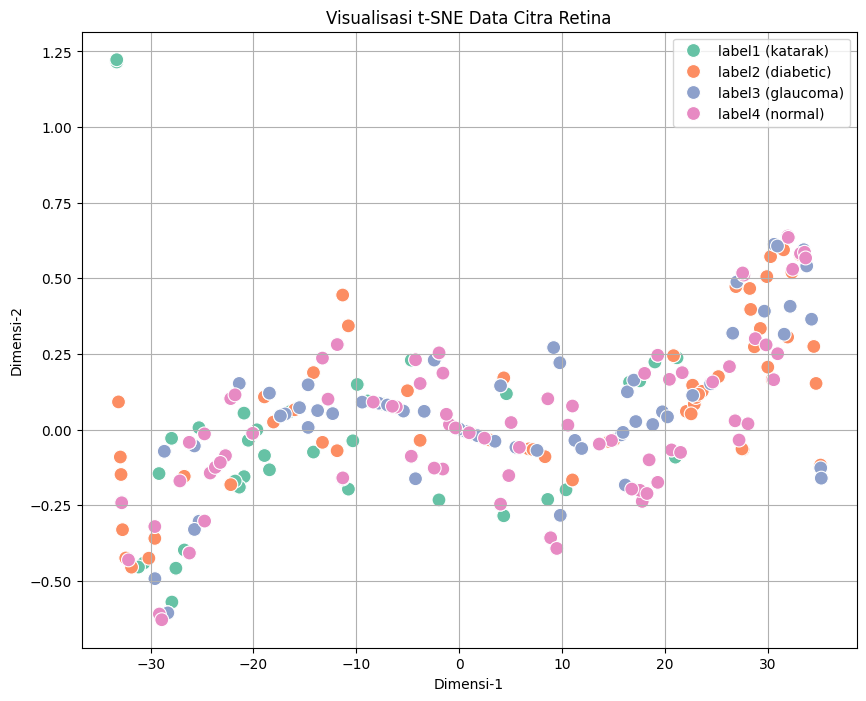

In [18]:
# Selection t-SNE

from sklearn.manifold import TSNE

# Jalankan t-SNE untuk reduksi ke 2 dimensi
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(x_new)

# Buat DataFrame hasil t-SNE
df_tsne = pd.DataFrame()
df_tsne['Dimensi-1'] = X_tsne[:, 0]
df_tsne['Dimensi-2'] = X_tsne[:, 1]
df_tsne['Label'] = y

# Plot dengan seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimensi-1', y='Dimensi-2', hue='Label', data=df_tsne, palette='Set2', s=100
)
plt.title('Visualisasi t-SNE Data Citra Retina')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Splitting Data

In [19]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(268, 6)
(68, 6)
(268,)
(68,)


## Feature Normalization

In [20]:
# normalisasi mean std (Standardization / Z-score normalization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [21]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [22]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.91      0.92      0.91        64
label2 (diabetic)       0.91      0.90      0.90        67
label3 (glaucoma)       0.85      0.89      0.87        72
  label4 (normal)       0.92      0.88      0.90        65

         accuracy                           0.90       268
        macro avg       0.90      0.90      0.90       268
     weighted avg       0.90      0.90      0.90       268

[[59  1  1  3]
 [ 2 60  4  1]
 [ 3  4 64  1]
 [ 1  1  6 57]]
Accuracy: 0.8955223880597015

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.47      0.45      0.46        20
label2 (diabetic)       0.43      0.53      0.47        17
label3 (glaucoma)       0.13      0.17      0.15        12
  label4 (normal)       0.54      0.37      0.44        19

         accuracy                           0.40        68
        macro avg       0.39 

### Train SVM Classifier

In [23]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.45      0.75      0.56        64
label2 (diabetic)       0.77      0.49      0.60        67
label3 (glaucoma)       0.54      0.56      0.55        72
  label4 (normal)       0.59      0.40      0.48        65

         accuracy                           0.55       268
        macro avg       0.59      0.55      0.55       268
     weighted avg       0.59      0.55      0.55       268

[[48  2 10  4]
 [15 33  9 10]
 [25  3 40  4]
 [19  5 15 26]]
Accuracy: 0.5485074626865671

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.46      0.55      0.50        20
label2 (diabetic)       0.67      0.47      0.55        17
label3 (glaucoma)       0.27      0.33      0.30        12
  label4 (normal)       0.47      0.42      0.44        19

         accuracy                           0.46        68
        macro avg       0.47

### Train KKN Classifier

In [24]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.51      0.80      0.62        64
label2 (diabetic)       0.65      0.49      0.56        67
label3 (glaucoma)       0.57      0.57      0.57        72
  label4 (normal)       0.58      0.40      0.47        65

         accuracy                           0.56       268
        macro avg       0.58      0.56      0.56       268
     weighted avg       0.58      0.56      0.56       268

[[51  2  5  6]
 [13 33 13  8]
 [19  7 41  5]
 [17  9 13 26]]
Accuracy: 0.5634328358208955

------Testing Set------
                   precision    recall  f1-score   support

 label1 (katarak)       0.46      0.55      0.50        20
label2 (diabetic)       0.69      0.53      0.60        17
label3 (glaucoma)       0.19      0.25      0.21        12
  label4 (normal)       0.60      0.47      0.53        19

         accuracy                           0.47        68
        macro avg       0.48

## Evaluasi Dengan Confussion Matrix

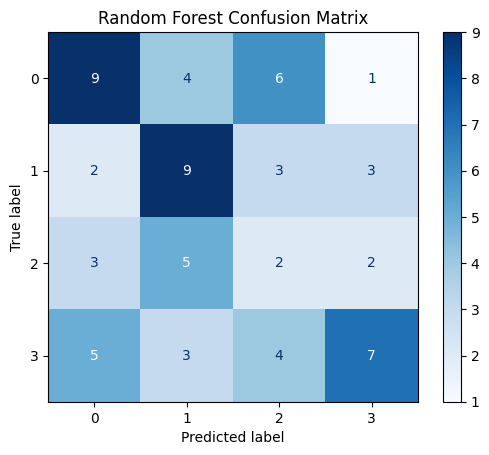

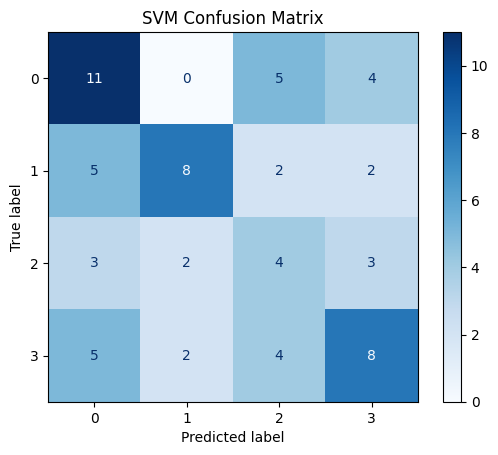

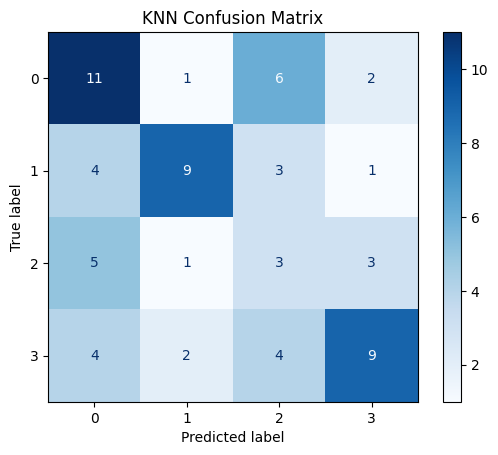

In [25]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")